In [56]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("sea_jpt_cn")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
ML = cfg.ML
POPULATIONS = cfg.POPULATIONS

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

# Classifiers
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


In [57]:
# Check if results already exist - skip expensive training if cached
from pathlib import Path
output_dir = PATHS.OUTPUT_DIR
ml_models_dir = project_root / "output" / "ml_models" / "sea_jpt_cn"

# Define required outputs to check for
REQUIRED_OUTPUTS = [
    output_dir / "statistical_ml_results.csv",
    output_dir / "statistical_top25_snps.csv",
    ml_models_dir / "fst_stat_top50_ml_data.csv",
    ml_models_dir / "fst_stat_top50_features.csv",
]

# Check if all required outputs exist
all_outputs_exist = all(Path(f).exists() for f in REQUIRED_OUTPUTS)

if all_outputs_exist:
    print("✅ All required output files already exist!")
    print("   Set SKIP_TRAINING = False to force re-training.")
    for f in REQUIRED_OUTPUTS:
        print(f"   - {f.name}")
    SKIP_TRAINING = True
else:
    print("⚠️ Some output files missing - will run full training pipeline")
    missing = [f.name for f in REQUIRED_OUTPUTS if not Path(f).exists()]
    print(f"   Missing: {missing}")
    SKIP_TRAINING = False

# Override: Set to False to force re-training even if cached
SKIP_TRAINING = False

print(f"\nSKIP_TRAINING = {SKIP_TRAINING}")

✅ All required output files already exist!
   Set SKIP_TRAINING = False to force re-training.
   - statistical_ml_results.csv
   - statistical_top25_snps.csv
   - fst_stat_top50_ml_data.csv
   - fst_stat_top50_features.csv

SKIP_TRAINING = False


## Step 1: Load Statistical Results and ML Data

In [58]:
# Load statistical SNP scores from 03b
stats_path = str(PATHS.OUTPUT_DIR / "statistics_snp_scores.csv")
print(f"Loading statistical results from: {stats_path}")

stats_df = pd.read_csv(stats_path)
print(f"Statistical results shape: {stats_df.shape}")
print(f"\nColumns: {list(stats_df.columns)}")

# Load ML data (genotype matrix with population labels)
ml_data_path = str(PATHS.ML_DATA)
print(f"\nLoading ML data from: {ml_data_path}")

df = pd.read_csv(ml_data_path)
print(f"ML data shape: {df.shape}")
print(f"\nPopulation distribution:")
print(df['pop'].value_counts())

Loading statistical results from: 1000genomes/output_sea_jpt_cn/statistics_snp_scores.csv
Statistical results shape: (2518, 21)

Columns: ['snp_id', 'chi2', 'chi2_pvalue', 'g_stat', 'g_pvalue', 'fisher_or', 'fisher_pvalue', 'mutual_information', 'information_gain', 'kl_divergence', 'lr_coef', 'lr_se', 'lr_zscore', 'lr_pvalue', 'lr_pseudo_r2', 'chi2_qvalue', 'chi2_significant_bonf', 'chi2_significant_fdr', 'lr_qvalue', 'lr_significant_bonf', 'lr_significant_fdr']

Loading ML data from: 1000genomes/vcf_sea_jpt_cn/vcf_numeric_transposed_with_population.csv
ML data shape: (504, 2520)

Population distribution:
pop
CN     208
SEA    192
JPT    104
Name: count, dtype: int64


In [59]:
# Prepare features and labels
sample_ids = df['sample']
populations = df['pop']
snp_columns = [c for c in df.columns if c not in ['sample', 'pop']]
X_all = df[snp_columns]
y = populations

print(f"Total samples: {len(df)}")
print(f"Total SNPs in ML data: {len(snp_columns)}")
print(f"\nFirst 5 SNP columns: {snp_columns[:5]}")

Total samples: 504
Total SNPs in ML data: 2518

First 5 SNP columns: ['16:602313', '16:896563', '16:2214387', '16:4519140', '16:5988291']


## Step 2: Identify Consensus SNPs (Significant in All 4 Tests)

In [60]:
# Define significance criteria for each test
# Using FDR-corrected significance for chi2, and top 500 for information-theoretic measures

# Check if significance columns exist
if 'chi2_significant_fdr' in stats_df.columns:
    sig_chi2 = set(stats_df[stats_df['chi2_significant_fdr']]['snp_id'])
else:
    # Fallback: use top 500 by chi2
    sig_chi2 = set(stats_df.nlargest(500, 'chi2')['snp_id'])

sig_mi = set(stats_df.nlargest(500, 'mutual_information')['snp_id'])
sig_ig = set(stats_df.nlargest(500, 'information_gain')['snp_id'])
sig_kl = set(stats_df.nlargest(500, 'kl_divergence')['snp_id'])

print("SNPs Selected by Each Test:")
print("="*60)
print(f"χ² test (FDR significant or top 500): {len(sig_chi2)}")
print(f"Mutual Information (top 500): {len(sig_mi)}")
print(f"Information Gain (top 500): {len(sig_ig)}")
print(f"KL Divergence (top 500): {len(sig_kl)}")

# Count SNPs appearing in multiple tests
all_sig_snps = list(sig_chi2) + list(sig_mi) + list(sig_ig) + list(sig_kl)
snp_counts = Counter(all_sig_snps)

# Get consensus SNPs
snps_in_4 = [s for s, c in snp_counts.items() if c == 4]
snps_in_3 = [s for s, c in snp_counts.items() if c >= 3]
snps_in_2 = [s for s, c in snp_counts.items() if c >= 2]

print(f"\nConsensus SNPs:")
print(f"  Significant in ALL 4 tests: {len(snps_in_4)}")
print(f"  Significant in ≥3 tests: {len(snps_in_3)}")
print(f"  Significant in ≥2 tests: {len(snps_in_2)}")

SNPs Selected by Each Test:
χ² test (FDR significant or top 500): 2518
Mutual Information (top 500): 500
Information Gain (top 500): 500
KL Divergence (top 500): 500

Consensus SNPs:
  Significant in ALL 4 tests: 205
  Significant in ≥3 tests: 500
  Significant in ≥2 tests: 795


In [61]:
# Select consensus SNPs for training
# Use SNPs significant in all 4 tests if enough, otherwise use ≥3

if len(snps_in_4) >= 50:
    consensus_snps = snps_in_4
    consensus_level = "all 4 tests"
elif len(snps_in_3) >= 50:
    consensus_snps = snps_in_3
    consensus_level = "≥3 tests"
else:
    consensus_snps = snps_in_2
    consensus_level = "≥2 tests"

print(f"Using {len(consensus_snps)} SNPs significant in {consensus_level}")

# Filter to SNPs that exist in ML data
available_consensus = [s for s in consensus_snps if s in snp_columns]
print(f"Available in ML data: {len(available_consensus)} SNPs")

# If still not enough, use top SNPs by composite score
if len(available_consensus) < 25:
    print("\nNot enough consensus SNPs. Using top SNPs by composite score...")
    # Create composite score (rank average)
    stats_df['rank_chi2'] = stats_df['chi2'].rank(ascending=False)
    stats_df['rank_mi'] = stats_df['mutual_information'].rank(ascending=False)
    stats_df['rank_ig'] = stats_df['information_gain'].rank(ascending=False)
    stats_df['rank_kl'] = stats_df['kl_divergence'].rank(ascending=False)
    stats_df['composite_rank'] = (stats_df['rank_chi2'] + stats_df['rank_mi'] + 
                                   stats_df['rank_ig'] + stats_df['rank_kl']) / 4
    
    top_composite = stats_df.nsmallest(500, 'composite_rank')['snp_id'].tolist()
    available_consensus = [s for s in top_composite if s in snp_columns]
    print(f"Using top {len(available_consensus)} SNPs by composite rank")

Using 205 SNPs significant in all 4 tests
Available in ML data: 205 SNPs


In [62]:
# Create training data with consensus SNPs
X_consensus = X_all[available_consensus]

print(f"\nConsensus Training Data:")
print(f"  Samples: {X_consensus.shape[0]}")
print(f"  Features (consensus SNPs): {X_consensus.shape[1]}")
print(f"\nFirst 10 consensus SNPs:")
for i, snp in enumerate(available_consensus[:10], 1):
    print(f"  {i}. {snp}")


Consensus Training Data:
  Samples: 504
  Features (consensus SNPs): 205

First 10 consensus SNPs:
  1. 18:18518431
  2. 11:123810763
  3. 14:105987782
  4. 1:158913641
  5. 16:56678700
  6. 4:143406773
  7. 13:46946428
  8. 7:84793684
  9. 11:61609751
  10. 7:157852607


## Step 3: Train Multiple Models on Consensus SNPs (LR, RF, XGBoost)

In [63]:
# Train/test split
if not SKIP_TRAINING:
    X_train, X_test, y_train, y_test = train_test_split(
        X_consensus, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Encode labels for XGBoost compatibility
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    print(f"\nClass encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    print("⏭️ Skipping train/test split - using cached results")

Training set: 403 samples
Test set: 101 samples

Class encoding: {'CN': 0, 'JPT': 1, 'SEA': 2}


In [64]:
# Train Multiple Models on consensus SNPs (LR, RF, XGBoost)
if not SKIP_TRAINING:
    # Scale data for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to compare
    step3_models = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1),
            'use_scaled': True,
            'use_encoded': False
        },
        'Random Forest': {
            'model': RandomForestClassifier(n_estimators=ML.RF_N_ESTIMATORS, max_depth=ML.RF_MAX_DEPTH, random_state=42, n_jobs=-1),
            'use_scaled': False,
            'use_encoded': False
        },
        'XGBoost': {
            'model': XGBClassifier(n_estimators=ML.XGB_N_ESTIMATORS, max_depth=ML.XGB_MAX_DEPTH, learning_rate=ML.XGB_LEARNING_RATE, random_state=42, n_jobs=-1, verbosity=0),
            'use_scaled': False,
            'use_encoded': True
        }
    }
    
    step3_results = []
    trained_models = {}
    
    print("Training Multiple Models on Consensus SNPs...")
    print("="*70)
    
    for name, config in step3_models.items():
        print(f"\nTraining {name}...")
        
        # Select appropriate data
        if config['use_scaled']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train.values, X_test.values
        
        if config['use_encoded']:
            y_tr, y_te = y_train_encoded, y_test_encoded
        else:
            y_tr, y_te = y_train, y_test
        
        # Train
        clf = config['model']
        clf.fit(X_tr, y_tr)
        trained_models[name] = clf
        
        # Predict
        y_pred = clf.predict(X_te)
        
        # Metrics
        acc = accuracy_score(y_te, y_pred)
        
        # Convert labels for consistent reporting
        if config['use_encoded']:
            y_te_str = le.inverse_transform(y_te)
            y_pred_str = le.inverse_transform(y_pred)
        else:
            y_te_str = y_te
            y_pred_str = y_pred
        
        prec = precision_score(y_te_str, y_pred_str, average='weighted')
        rec = recall_score(y_te_str, y_pred_str, average='weighted')
        f1 = f1_score(y_te_str, y_pred_str, average='weighted')
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_tr, y_tr, cv=cv, scoring='accuracy')
        
        step3_results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std()
        })
        
        print(f"  Accuracy: {acc:.4f} | F1: {f1:.4f} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Create results DataFrame
    step3_results_df = pd.DataFrame(step3_results).sort_values('Accuracy', ascending=False)
    
    print("\n" + "="*70)
    print("STEP 3 MODEL COMPARISON RESULTS")
    print("="*70)
    display(step3_results_df)
    
    # Select best model for feature importance
    best_model_name = step3_results_df.iloc[0]['Model']
    best_model_accuracy = step3_results_df.iloc[0]['Accuracy']
    print(f"\n★ Best Model: {best_model_name} (Accuracy: {best_model_accuracy:.4f})")
    print(f"  This model will be used for feature importance and SNP selection.")
    
    # Store for later use
    best_step3_model = trained_models[best_model_name]
else:
    print("⏭️ Skipping multi-model training - using cached results")

Training Multiple Models on Consensus SNPs...

Training Logistic Regression...


  Accuracy: 0.9307 | F1: 0.9307 | CV: 0.9702 ± 0.0125

Training Random Forest...
  Accuracy: 0.9406 | F1: 0.9404 | CV: 0.9478 ± 0.0185

Training XGBoost...
  Accuracy: 0.9406 | F1: 0.9400 | CV: 0.9181 ± 0.0186

STEP 3 MODEL COMPARISON RESULTS


,Model,Accuracy,Precision,Recall,F1-Score,CV Mean,CV Std
1,Random Forest,0.940594,0.943376,0.940594,0.940365,0.947809,0.018457
2,XGBoost,0.940594,0.942767,0.940594,0.940016,0.918086,0.018600
0,Logistic Regression,0.930693,0.932866,0.930693,0.930720,0.970247,0.012543



★ Best Model: Random Forest (Accuracy: 0.9406)
  This model will be used for feature importance and SNP selection.


In [65]:
# Get feature importances from best model and select top SNPs
if not SKIP_TRAINING:
    # For RF and XGBoost, use feature_importances_
    # For Logistic Regression, use coefficient magnitudes
    if best_model_name in ['Random Forest', 'XGBoost']:
        importances = best_step3_model.feature_importances_
    else:  # Logistic Regression
        # Use mean absolute coefficient across classes
        importances = np.mean(np.abs(best_step3_model.coef_), axis=0)
    
    feature_importance = pd.DataFrame({
        'snp': available_consensus,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Add statistical scores
    feature_importance = feature_importance.merge(
        stats_df[['snp_id', 'chi2', 'mutual_information', 'information_gain', 'kl_divergence']],
        left_on='snp', right_on='snp_id', how='left'
    ).drop('snp_id', axis=1)

    print(f"Top 25 SNPs by {best_model_name} Importance:")
    print("="*80)
    display(feature_importance.head(25))
else:
    # Load cached feature importance
    cached_path = output_dir / "statistical_top25_snps.csv"
    if cached_path.exists():
        feature_importance = pd.read_csv(cached_path)
        print("⏭️ Loaded cached feature importance")
        display(feature_importance.head(25))
    else:
        print("⏭️ Skipping feature importance - cached file not found")

Top 25 SNPs by Random Forest Importance:


,snp,importance,chi2,mutual_information,information_gain,kl_divergence
0,19:54792079,0.032861,147.862669,0.161159,0.232503,0.557670
1,4:17813761,0.028752,175.081948,0.192157,0.277224,3.878612
2,16:46417894,0.024750,91.093489,0.100690,0.145264,1.529946
3,16:33974960,0.023406,77.153763,0.081076,0.116968,0.356747
4,3:152553769,0.021341,115.513595,0.129657,0.187056,0.563399
5,12:4388084,0.017826,97.224354,0.079574,0.114801,0.249333
6,9:37486004,0.017687,85.923077,0.090649,0.130779,0.290066
7,1:12387655,0.017452,159.962062,0.173566,0.250402,3.868477
8,21:38533017,0.016176,140.276518,0.141221,0.203739,0.411417
9,5:41181491,0.016057,142.028434,0.155135,0.223812,3.279970


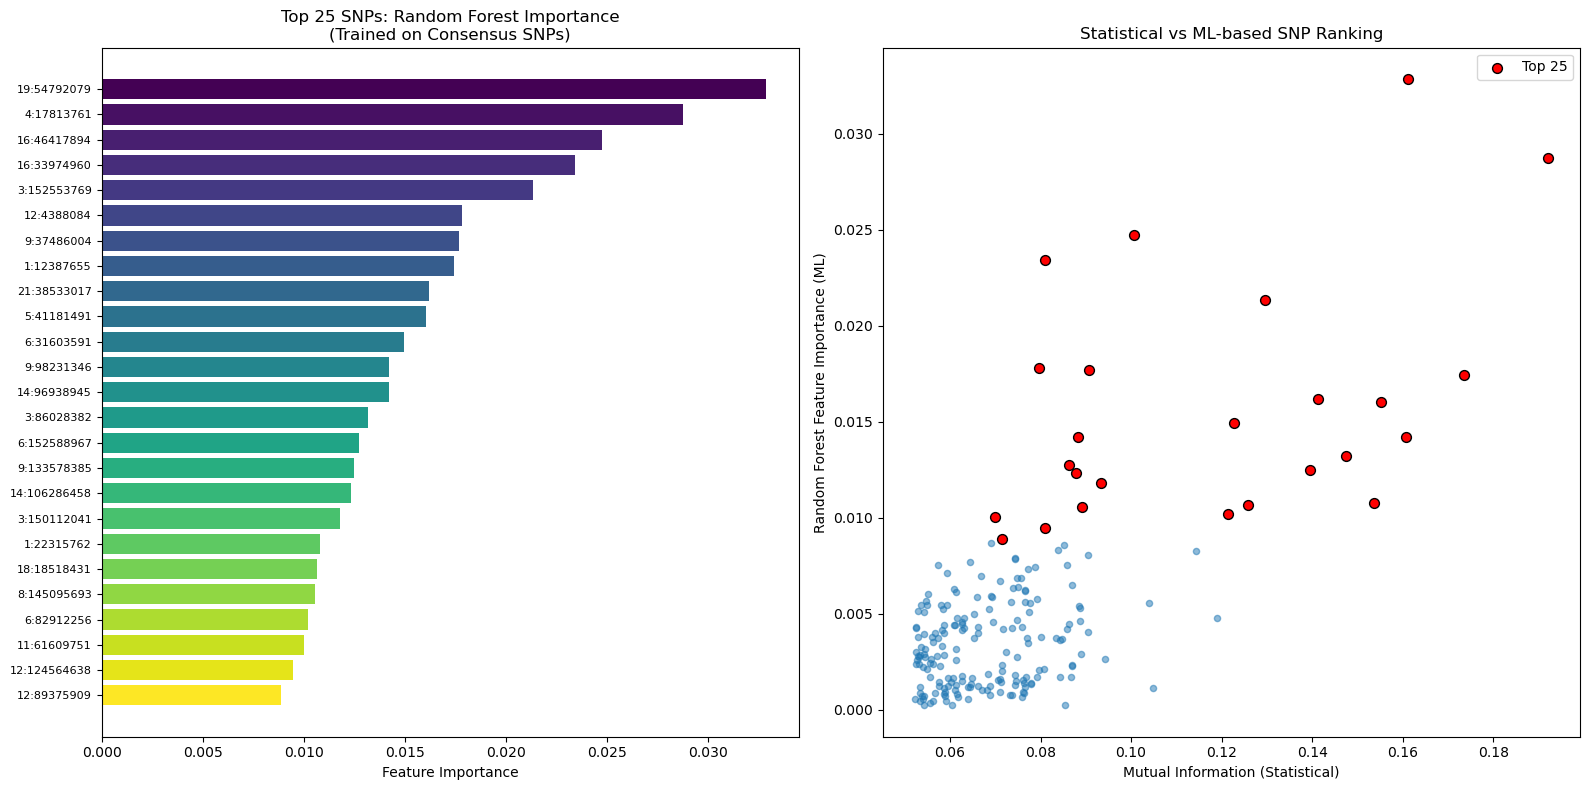

In [66]:
# Visualize feature importance
if not SKIP_TRAINING:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Top 25 importance from best model
    ax = axes[0]
    top_25_df = feature_importance.head(25)
    colors = plt.cm.viridis(np.linspace(0, 1, 25))
    bars = ax.barh(range(25), top_25_df['importance'].values, color=colors)
    ax.set_yticks(range(25))
    ax.set_yticklabels(top_25_df['snp'].values, fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Top 25 SNPs: {best_model_name} Importance\n(Trained on Consensus SNPs)')

    # Plot 2: Importance vs MI scatter
    ax = axes[1]
    ax.scatter(feature_importance['mutual_information'], 
               feature_importance['importance'], alpha=0.5, s=20)
    # Highlight top 25
    top_25_snps = feature_importance.head(25)['snp'].tolist()
    top_25_mask = feature_importance['snp'].isin(top_25_snps)
    ax.scatter(feature_importance.loc[top_25_mask, 'mutual_information'],
               feature_importance.loc[top_25_mask, 'importance'],
               color='red', s=50, label='Top 25', edgecolors='black')
    ax.set_xlabel('Mutual Information (Statistical)')
    ax.set_ylabel(f'{best_model_name} Feature Importance (ML)')
    ax.set_title('Statistical vs ML-based SNP Ranking')
    ax.legend()

    plt.tight_layout()
    plt.show()
else:
    # Still define top_25_snps from cached feature_importance
    top_25_snps = feature_importance.head(25)['snp'].tolist()
    print("⏭️ Skipping feature importance visualization - using cached results")

## Step 4: Train Best Model with Varying SNP Counts (25-50)

Using the best performing model from Step 3, systematically evaluate performance with different numbers of top SNPs (25, 30, 35, 40, 45, 50) to find the optimal feature set size.

In [67]:
# Define SNP counts to evaluate using best model from Step 3
if not SKIP_TRAINING:
    snp_counts = [25, 30, 35, 40, 45, 50]
    
    print(f"★ Using best model from Step 3: {best_model_name}")
    print(f"Evaluating with SNP counts: {snp_counts}")
    print()
    
    # TabPFN temporarily disabled
    TABPFN_AVAILABLE = False
else:
    TABPFN_AVAILABLE = False
    print("⏭️ Skipping setup - using cached results")

★ Using best model from Step 3: Random Forest
Evaluating with SNP counts: [25, 30, 35, 40, 45, 50]



In [68]:
# Train best model with varying SNP counts
if not SKIP_TRAINING:
    varying_snp_results = []
    
    # Determine if best model needs scaled data or encoded labels
    best_model_config = step3_models[best_model_name]

    for n_snps in snp_counts:
        print(f"\n{'='*60}")
        print(f"Training {best_model_name} with TOP {n_snps} SNPs")
        print(f"{'='*60}")
        
        # Get top N SNPs
        top_n_snps = feature_importance.head(n_snps)['snp'].tolist()
        X_topn = X_all[top_n_snps]
        
        # Train/test split (same random state for comparability)
        X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
            X_topn, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Encode labels
        y_train_n_enc = le.fit_transform(y_train_n)
        y_test_n_enc = le.transform(y_test_n)
        
        # Scale for algorithms that need it
        scaler_n = StandardScaler()
        X_train_n_scaled = scaler_n.fit_transform(X_train_n)
        X_test_n_scaled = scaler_n.transform(X_test_n)
        
        # Create fresh instance of best model
        if best_model_name == 'Random Forest':
            clf = RandomForestClassifier(n_estimators=ML.RF_N_ESTIMATORS, max_depth=ML.RF_MAX_DEPTH, random_state=42, n_jobs=-1)
        elif best_model_name == 'XGBoost':
            clf = XGBClassifier(n_estimators=ML.XGB_N_ESTIMATORS, max_depth=ML.XGB_MAX_DEPTH, learning_rate=ML.XGB_LEARNING_RATE, random_state=42, n_jobs=-1, verbosity=0)
        elif best_model_name == 'Logistic Regression':
            clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1)
        
        # Select appropriate data
        if best_model_config['use_scaled']:
            X_tr, X_te = X_train_n_scaled, X_test_n_scaled
        else:
            X_tr, X_te = X_train_n.values, X_test_n.values
        
        if best_model_config['use_encoded']:
            y_tr, y_te = y_train_n_enc, y_test_n_enc
        else:
            y_tr, y_te = y_train_n, y_test_n
        
        try:
            clf.fit(X_tr, y_tr)
            y_pred = clf.predict(X_te)
            
            acc = accuracy_score(y_te, y_pred)
            
            # Convert labels for consistent scoring
            if best_model_config['use_encoded']:
                y_te_str = le.inverse_transform(y_te)
                y_pred_str = le.inverse_transform(y_pred)
            else:
                y_te_str = y_te
                y_pred_str = y_pred
            
            f1 = f1_score(y_te_str, y_pred_str, average='weighted')
            
            # Cross-validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(clf, X_tr, y_tr, cv=cv, scoring='accuracy')
            
            varying_snp_results.append({
                'N_SNPs': n_snps,
                'Model': best_model_name,
                'Accuracy': acc,
                'F1-Score': f1,
                'CV Mean': cv_scores.mean(),
                'CV Std': cv_scores.std()
            })
            
            print(f"  Accuracy: {acc:.4f} | F1: {f1:.4f} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            
        except Exception as e:
            print(f"  Error: {e}")

    # Create results DataFrame
    varying_results_df = pd.DataFrame(varying_snp_results)
    print(f"\n\nTotal experiments: {len(varying_results_df)}")
    
    # Find best SNP count
    best_snp_config = varying_results_df.loc[varying_results_df['Accuracy'].idxmax()]
    print(f"\n★ Best Configuration:")
    print(f"  Model: {best_snp_config['Model']}")
    print(f"  Optimal SNP Count: {int(best_snp_config['N_SNPs'])}")
    print(f"  Accuracy: {best_snp_config['Accuracy']:.4f}")
    print(f"  F1-Score: {best_snp_config['F1-Score']:.4f}")
    print(f"  CV Mean: {best_snp_config['CV Mean']:.4f}")
    
    # Store optimal SNP count for later use
    optimal_snp_count = int(best_snp_config['N_SNPs'])
else:
    # Load cached varying results if available
    cached_varying_path = ml_models_dir / "fst_stat_varying_snp_results.csv"
    if cached_varying_path.exists():
        varying_results_df = pd.read_csv(cached_varying_path)
        print("⏭️ Loaded cached varying SNP results")
    else:
        varying_results_df = pd.DataFrame()
        print("⏭️ Skipping varying SNP training - no cached results available")


Training Random Forest with TOP 25 SNPs
  Accuracy: 0.8416 | F1: 0.8371 | CV: 0.8860 ± 0.0236

Training Random Forest with TOP 30 SNPs
  Accuracy: 0.8614 | F1: 0.8576 | CV: 0.8834 ± 0.0199

Training Random Forest with TOP 35 SNPs
  Accuracy: 0.8812 | F1: 0.8789 | CV: 0.9033 ± 0.0162

Training Random Forest with TOP 40 SNPs
  Accuracy: 0.9010 | F1: 0.9005 | CV: 0.9132 ± 0.0134

Training Random Forest with TOP 45 SNPs
  Accuracy: 0.9208 | F1: 0.9195 | CV: 0.9207 ± 0.0214

Training Random Forest with TOP 50 SNPs
  Accuracy: 0.8911 | F1: 0.8900 | CV: 0.9306 ± 0.0125


Total experiments: 6

★ Best Configuration:
  Model: Random Forest
  Optimal SNP Count: 45
  Accuracy: 0.9208
  F1-Score: 0.9195
  CV Mean: 0.9207


In [69]:
# Display results table
if not SKIP_TRAINING and len(varying_results_df) > 0:
    print(f"\n{best_model_name} Performance by SNP Count:")
    print("="*70)
    display(varying_results_df.round(4))
else:
    print("⏭️ Skipping results display - using cached results or no data available")


Random Forest Performance by SNP Count:


,N_SNPs,Model,Accuracy,F1-Score,CV Mean,CV Std
0,25,Random Forest,0.8416,0.8371,0.8860,0.0236
1,30,Random Forest,0.8614,0.8576,0.8834,0.0199
2,35,Random Forest,0.8812,0.8789,0.9033,0.0162
3,40,Random Forest,0.9010,0.9005,0.9132,0.0134
4,45,Random Forest,0.9208,0.9195,0.9207,0.0214
5,50,Random Forest,0.8911,0.8900,0.9306,0.0125


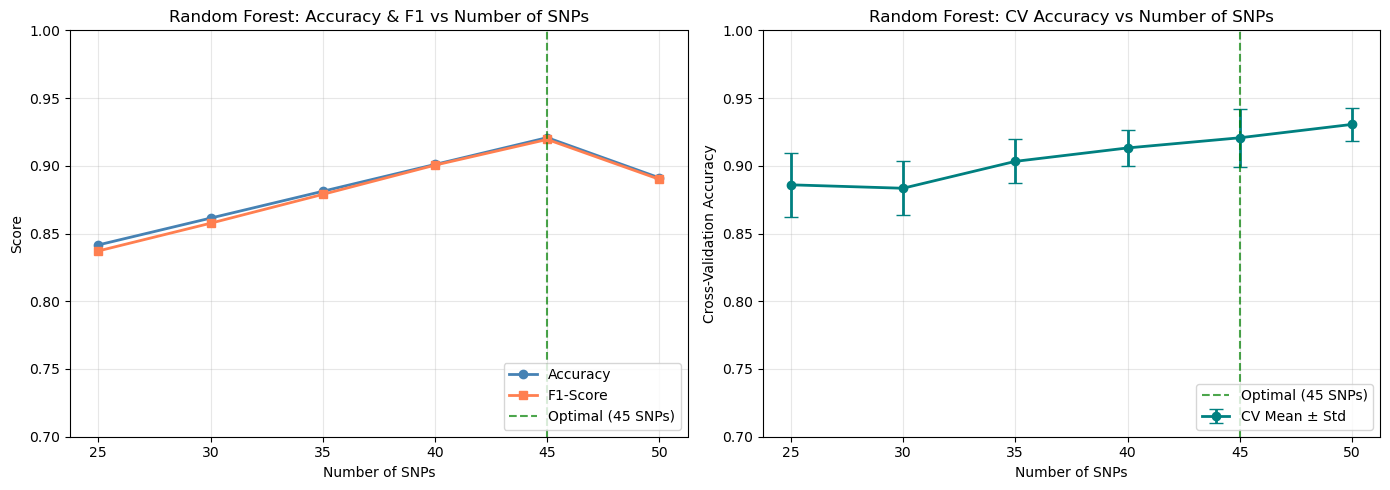


Plot saved to: 1000genomes/output_sea_jpt_cn/varying_snp_performance.png


In [70]:
# Visualization: Performance vs SNP Count for best model
if not SKIP_TRAINING and len(varying_results_df) > 0:
    snp_counts_list = sorted(varying_results_df['N_SNPs'].unique())
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Accuracy and F1 vs SNP Count
    ax = axes[0]
    ax.plot(varying_results_df['N_SNPs'], varying_results_df['Accuracy'], 
            marker='o', label='Accuracy', linewidth=2, color='steelblue')
    ax.plot(varying_results_df['N_SNPs'], varying_results_df['F1-Score'], 
            marker='s', label='F1-Score', linewidth=2, color='coral')
    ax.axvline(x=optimal_snp_count, color='green', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_snp_count} SNPs)')
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Score')
    ax.set_title(f'{best_model_name}: Accuracy & F1 vs Number of SNPs')
    ax.legend(loc='lower right')
    ax.set_xticks(snp_counts_list)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.7, 1.0)

    # Plot 2: CV Mean with Error Bars
    ax = axes[1]
    ax.errorbar(varying_results_df['N_SNPs'], varying_results_df['CV Mean'], 
                yerr=varying_results_df['CV Std'], marker='o', capsize=5, 
                linewidth=2, color='teal', label='CV Mean ± Std')
    ax.axvline(x=optimal_snp_count, color='green', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_snp_count} SNPs)')
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Cross-Validation Accuracy')
    ax.set_title(f'{best_model_name}: CV Accuracy vs Number of SNPs')
    ax.legend(loc='lower right')
    ax.set_xticks(snp_counts_list)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.7, 1.0)

    plt.tight_layout()
    plt.savefig(str(PATHS.OUTPUT_DIR / "varying_snp_performance.png"), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPlot saved to: {PATHS.OUTPUT_DIR / 'varying_snp_performance.png'}")
else:
    print("⏭️ Skipping varying SNP visualization - using cached results")

In [71]:
# Save varying SNP results
if not SKIP_TRAINING and len(varying_results_df) > 0:
    varying_results_path = str(PATHS.OUTPUT_DIR / "varying_snp_results.csv")
    varying_results_df.to_csv(varying_results_path, index=False)
    print(f"Varying SNP results saved to: {varying_results_path}")

    # Also save to ml_models_dir for consistency
    varying_results_df.to_csv(ml_models_dir / "fst_stat_varying_snp_results.csv", index=False)

    # Summary
    print("\n" + "="*70)
    print(f"SUMMARY: {best_model_name} PERFORMANCE BY SNP COUNT")
    print("="*70)
    print(f"\nBest Model: {best_model_name}")
    print(f"Optimal SNP Count: {optimal_snp_count}")
    print(f"Best Accuracy: {varying_results_df['Accuracy'].max():.4f}")
    print(f"Best F1-Score: {varying_results_df['F1-Score'].max():.4f}")
    print(f"Best CV Mean: {varying_results_df['CV Mean'].max():.4f}")
else:
    print("⏭️ Skipping varying SNP results saving - using cached results")

Varying SNP results saved to: 1000genomes/output_sea_jpt_cn/varying_snp_results.csv

SUMMARY: Random Forest PERFORMANCE BY SNP COUNT

Best Model: Random Forest
Optimal SNP Count: 45
Best Accuracy: 0.9208
Best F1-Score: 0.9195
Best CV Mean: 0.9306


## Step 5: Compare with FST-based Selection (if available)

In [72]:
# Try to load FST-based top SNPs for comparison
if not SKIP_TRAINING:
    try:
        fst_top_snps_path = str(PATHS.TOP_SNPS_FILE)
        fst_top_snps = pd.read_csv(fst_top_snps_path)['ID'].tolist()[:TOP_N]
        
        print(f"Loaded {len(fst_top_snps)} FST-selected SNPs")
        
        # Check overlap
        overlap = set(top_25_snps) & set(fst_top_snps)
        print(f"\nOverlap between methods:")
        print(f"  Statistical top {TOP_N}: {len(top_25_snps)} SNPs")
        print(f"  FST-based top {TOP_N}: {len(fst_top_snps)} SNPs")
        print(f"  Shared SNPs: {len(overlap)} ({100*len(overlap)/TOP_N:.1f}%)")
        
        if len(overlap) > 0:
            print(f"\nShared SNPs:")
            for snp in list(overlap)[:10]:
                print(f"  - {snp}")
            if len(overlap) > 10:
                print(f"  ... and {len(overlap) - 10} more")
                
    except Exception as e:
        print(f"FST comparison not available: {e}")
        print("Run 03_fst_and_pca.ipynb first to generate FST-selected SNPs.")
else:
    print("⏭️ Skipping FST comparison - using cached results")

FST comparison not available: 'ID'
Run 03_fst_and_pca.ipynb first to generate FST-selected SNPs.


## Step 6: Save Results

In [73]:
# Save model comparison results
if not SKIP_TRAINING:
    # Save results table
    results_path = str(output_dir / "statistical_ml_results.csv")
    results_df.to_csv(results_path, index=False)
    print(f"Model results saved to: {results_path}")

    # Save top 25 SNPs with importance
    top25_path = str(output_dir / "statistical_top25_snps.csv")
    feature_importance.head(TOP_N).to_csv(top25_path, index=False)
    print(f"Top 25 SNPs saved to: {top25_path}")

    # Save top 25 SNP IDs for external use
    top25_ids_path = str(output_dir / "statistical_top25_snp_ids.txt")
    with open(top25_ids_path, 'w') as f:
        for snp in top_25_snps:
            f.write(f"{snp}\n")
    print(f"Top 25 SNP IDs saved to: {top25_ids_path}")

    # Save report
    report_path = str(project_root / "reports" / "sea_jpt_cn" / "statistical_ml_report.txt")
    Path(report_path).parent.mkdir(parents=True, exist_ok=True)
    with open(report_path, 'w') as f:
        f.write("="*70 + "\n")
        f.write("ML TRAINING ON STATISTICALLY-SELECTED SNPs\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"Dataset:\n")
        f.write(f"  Samples: {len(df)}\n")
        f.write(f"  Populations: {list(y.unique())}\n")
        f.write(f"  Consensus SNPs: {len(available_consensus)}\n")
        f.write(f"  Top SNPs used: {TOP_N}\n\n")
        
        f.write(f"Model Results (Top 25 SNPs):\n")
        f.write("-"*70 + "\n")
        for _, row in results_df.iterrows():
            f.write(f"  {row['Model']:25} | Acc: {row['Accuracy']:.4f} | F1: {row['F1-Score']:.4f} | CV: {row['CV Mean']:.4f}\n")
        
        f.write(f"\nBest Model: {results_df.iloc[0]['Model']}\n")
        f.write(f"  Accuracy: {results_df.iloc[0]['Accuracy']:.4f}\n")
        f.write(f"  F1-Score: {results_df.iloc[0]['F1-Score']:.4f}\n")

    print(f"Report saved to: {report_path}")
else:
    print("⏭️ Skipping model results saving - using cached results")

Model results saved to: 1000genomes/output_sea_jpt_cn/statistical_ml_results.csv
Top 25 SNPs saved to: 1000genomes/output_sea_jpt_cn/statistical_top25_snps.csv
Top 25 SNP IDs saved to: 1000genomes/output_sea_jpt_cn/statistical_top25_snp_ids.txt
Report saved to: /home/Plutonium/Documents/BioinfoMidterm/reports/sea_jpt_cn/statistical_ml_report.txt


In [74]:
# Save Top 50 FST+Statistical SNPs ML Data Matrix for Part 2 comparison
if not SKIP_TRAINING:
    TOP_50 = 50

    # Get top 50 SNP names from feature importance
    top_50_snps = feature_importance.head(TOP_50)['snp'].tolist()

    # Create ML data matrix with only top 50 SNPs
    # Get top 50 SNP columns that exist in the data
    top_50_snp_cols = [c for c in top_50_snps if c in snp_columns]
    print(f"Top 50 SNPs available in ML data: {len(top_50_snp_cols)}")

    # Create the top 50 ML data matrix
    stat_top50_df = df[['sample', 'pop'] + top_50_snp_cols].copy()

    # Save to ml_models_dir
    stat_top50_path = ml_models_dir / "fst_stat_top50_ml_data.csv"
    stat_top50_df.to_csv(stat_top50_path, index=False)
    print(f"\nFST+Statistical Top 50 ML data saved to: {stat_top50_path}")
    print(f"  Samples: {len(stat_top50_df)}")
    print(f"  SNPs: {len(top_50_snp_cols)}")

    # Also save top 50 SNP IDs for reference
    top50_ids_path = ml_models_dir / "fst_stat_top50_snp_ids.txt"
    with open(top50_ids_path, 'w') as f:
        for snp in top_50_snp_cols:
            f.write(f"{snp}\n")
    print(f"Top 50 SNP IDs saved to: {top50_ids_path}")

    # Save top 50 feature importance with stats
    top50_importance_path = ml_models_dir / "fst_stat_top50_features.csv"
    feature_importance.head(TOP_50).to_csv(top50_importance_path, index=False)
    print(f"Top 50 feature importance saved to: {top50_importance_path}")
else:
    print("⏭️ Skipping Top 50 ML data saving - using cached results")

Top 50 SNPs available in ML data: 50

FST+Statistical Top 50 ML data saved to: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/fst_stat_top50_ml_data.csv
  Samples: 504
  SNPs: 50
Top 50 SNP IDs saved to: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/fst_stat_top50_snp_ids.txt
Top 50 feature importance saved to: /home/Plutonium/Documents/BioinfoMidterm/output/ml_models/sea_jpt_cn/fst_stat_top50_features.csv


In [75]:
# Final Summary
print("="*70)
print("STATISTICAL SNP ML TRAINING SUMMARY")
print("="*70)

if SKIP_TRAINING:
    print("\n⏭️ SKIP_TRAINING MODE: Using cached results")
    print(f"\nCached files loaded from:")
    print(f"  - {output_dir / 'statistical_ml_results.csv'}")
    print(f"  - {ml_models_dir / 'fst_stat_top50_ml_data.csv'}")
else:
    print(f"\nDataset:")
    print(f"  Samples: {len(df)}")
    print(f"  Populations: {list(y.unique())}")

    print(f"\nSNP Selection:")
    print(f"  Consensus SNPs (from 03b): {len(available_consensus)}")
    print(f"  Top SNPs for final training: {TOP_N}")

    print(f"\nBest Performing Models:")
    for i, row in results_df.head(3).iterrows():
        print(f"  {i+1}. {row['Model']}: {row['Accuracy']:.4f} accuracy")

    print(f"\nTop 5 SNPs by Importance:")
    for i, row in feature_importance.head(5).iterrows():
        print(f"  {i+1}. {row['snp']} (importance: {row['importance']:.4f}, MI: {row['mutual_information']:.4f})")

print(f"\nOutput Files:")
print(f"  - statistical_ml_results.csv")
print(f"  - statistical_top25_snps.csv")
print(f"  - statistical_top25_snp_ids.txt")
print(f"  - fst_stat_top50_ml_data.csv")
print(f"  - reports/sea_jpt_cn/statistical_ml_report.txt")

print(f"\nNext Steps:")
print(f"  - Compare with FST-based results (04a_fst_only_training.ipynb)")
print(f"  - Use 08b for comparison with known AISNP panels")
print(f"  - Apply to external validation datasets")

STATISTICAL SNP ML TRAINING SUMMARY

Dataset:
  Samples: 504
  Populations: ['CN', 'SEA', 'JPT']

SNP Selection:
  Consensus SNPs (from 03b): 205
  Top SNPs for final training: 25

Best Performing Models:
  1. Random Forest: 0.8416 accuracy
  2. XGBoost: 0.8416 accuracy
  5. SVM (Linear): 0.8416 accuracy

Top 5 SNPs by Importance:
  1. 19:54792079 (importance: 0.0329, MI: 0.1612)
  2. 4:17813761 (importance: 0.0288, MI: 0.1922)
  3. 16:46417894 (importance: 0.0247, MI: 0.1007)
  4. 16:33974960 (importance: 0.0234, MI: 0.0811)
  5. 3:152553769 (importance: 0.0213, MI: 0.1297)

Output Files:
  - statistical_ml_results.csv
  - statistical_top25_snps.csv
  - statistical_top25_snp_ids.txt
  - fst_stat_top50_ml_data.csv
  - reports/sea_jpt_cn/statistical_ml_report.txt

Next Steps:
  - Compare with FST-based results (04a_fst_only_training.ipynb)
  - Use 08b for comparison with known AISNP panels
  - Apply to external validation datasets
